In [3]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from common.training import *
from common.utils import load_sql_to_df, save_to_sql, plot_history

import datasets
import data_process as dp
from models import SentimentAnalysisLSTM, SentimentAnalysisGRU, SentimentAnalysisRNN

import numpy as np
import pandas as pd
import sqlite3 as db
import torchtext
import torch
import torch.utils
import matplotlib.pyplot as plt
from langdetect import detect_langs, detect
from tqdm import tqdm_notebook

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [3]:
#reproducibility
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

## Load data

In [5]:
important_columns = ["position", "move", "comment", "sentiment"]
gameknot_moves_df = load_sql_to_df("SELECT * FROM english_annotated_moves", "../../chess.db")[important_columns]
gameknot_moves_df

,position,move,comment,sentiment
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1
3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1
4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0
...,...,...,...,...
326634,rnb5/p2p1P1N/7p/1pR5/6P1/4k3/2P1B3/3Q1RK1 b - ...,b5b4,Pawn,-1
326635,rnb5/p2p1P1N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f7f8q,Check mate in two moves,-1
326636,rnb2Q2/p2p3N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 b -...,d7d6,Pawn,-1
326637,rnb2Q2/p6N/3p3p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f8e8,Check,-1


In [6]:
chessbase_moves_df = load_sql_to_df("SELECT * FROM chessbase_moves_with_comments_2", "../../chess.db")
chessbase_moves_df = chessbase_moves_df[chessbase_moves_df.is_english == 1][important_columns]
chessbase_moves_df

,position,move,comment,sentiment
9,r1bq1k1r/ppppnBpp/8/6B1/3P4/1Q3N2/P4PPP/b4RK1 ...,f3e5,\n[%csl Gf7],-1
10,r1bq1k1r/ppppnBpp/8/4N1B1/3P4/1Q6/P4PPP/b4RK1 ...,a1d4,"Black tries to capture as much as possible, an...",-1
11,r1bq1k1r/ppppnBpp/8/4N1B1/3b4/1Q6/P4PPP/5RK1 w...,f7g6,[%csl Gf7] aha! If the king has not yet castle...,-1
13,r1bq1k1r/ppp1n1pp/6B1/3pN1B1/3b4/1Q6/P4PPP/5RK...,b3f3,"No mate, but..",-1
14,r2qk2r/ppp1n1pp/4BB2/3p4/8/5Q2/P4PPP/5RK1 w - ...,f6g7,"Powerful bishops, discovered by Greco. This\ns...",-1
...,...,...,...,...
1633567,rn1q1rk1/1b3ppp/1p1ppn2/p1p5/1PP5/P1Q1PN2/1B1P...,b4b5,It is probably a good idea for White to comple...,-1
1633568,r4rk1/1b1nqppp/1p1p1n2/pPp1p3/2P5/P1QPPN2/1B2B...,h1g1,White does not absolutely have to play with g4...,-1
1633571,rn1qk2r/1bpp1ppp/1p2pn2/p7/1PP5/P1Q5/1B1PPPPP/...,f2f3,"A somewhat unusual move, but specifically in t...",-1
1633580,rnbq1rk1/pp1pnppp/4p3/2pP4/2P1P3/2P2N2/P4PPP/R...,d7d6,leads to a complicated position with chances f...,-1


In [7]:
moves_df = pd.concat((gameknot_moves_df, chessbase_moves_df), axis=0)
# moves_df = gameknot_moves_df
moves_df

,position,move,comment,sentiment
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1
3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1
4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0
...,...,...,...,...
1633567,rn1q1rk1/1b3ppp/1p1ppn2/p1p5/1PP5/P1Q1PN2/1B1P...,b4b5,It is probably a good idea for White to comple...,-1
1633568,r4rk1/1b1nqppp/1p1p1n2/pPp1p3/2P5/P1QPPN2/1B2B...,h1g1,White does not absolutely have to play with g4...,-1
1633571,rn1qk2r/1bpp1ppp/1p2pn2/p7/1PP5/P1Q5/1B1PPPPP/...,f2f3,"A somewhat unusual move, but specifically in t...",-1
1633580,rnbq1rk1/pp1pnppp/4p3/2pP4/2P1P3/2P2N2/P4PPP/R...,d7d6,leads to a complicated position with chances f...,-1


## Preprocessing

In [8]:
glove_50 = torchtext.vocab.GloVe(name="6B", dim=50, cache="../../.vector_cache/")
glove_100 = torchtext.vocab.GloVe(name="6B", dim=100, cache="../../.vector_cache/")
glove_200 = torchtext.vocab.GloVe(name="6B", dim=200, cache="../../.vector_cache/")
glove_300 = torchtext.vocab.GloVe(name="6B", dim=300, cache="../../.vector_cache/")

datasets.add_padding_vector_to_embeddings(glove_50)
datasets.add_padding_vector_to_embeddings(glove_100)
datasets.add_padding_vector_to_embeddings(glove_200)
datasets.add_padding_vector_to_embeddings(glove_300)

In [9]:
glove_embbedings = glove_50

In [10]:
comments_df = dp.prepare_data_for_sentiment_analysis_training(moves_df, glove_embbedings.stoi, max_len=150)
comments_df

,comment,sentiment,preprocessed_comment
112225,forcing stalemate,1,"[force, stalemate]"
35148,[ csl,1,"[[, csl]"
47635,[ cal,1,"[[, cal]"
16606,[ cal,1,"[[, cal]"
18391,[ csl,1,"[[, csl]"
...,...,...,...
7388,?? now this move looks good and is a common re...,0,"[?, ?, now, this, move, look, good, and, be, a..."
127242,this also develops but i view it as an inaccur...,0,"[this, also, develop, but, view, it, as, an, i..."
128275,not knowing what else to do here i played this...,0,"[not, know, what, else, to, do, here, play, th..."
6225,?? this move however is even worse. in fact it...,0,"[?, ?, this, move, however, be, even, bad, ., ..."


In [11]:
train_df, test_df = dp.df_train_test_split(comments_df, comment_col='preprocessed_comment', test_size=0.05)
display(train_df)
display(test_df)

,comment,sentiment,preprocessed_comment
7466,? alternative,0,"[?, alternative]"
4935,? pointless,0,"[?, pointless]"
15725,horn pe,1,"[horn, pe]"
22399,[ csl,1,"[[, csl]"
99464,[ cal,1,"[[, cal]"
...,...,...,...
3050,! plenty of other bishop moves are good but th...,1,"[!, plenty, of, other, bishop, move, be, good,..."
124713,jack stockel accurately pointed out that this ...,0,"[jack, accurately, point, out, that, this, be,..."
6225,?? this move however is even worse. in fact it...,0,"[?, ?, this, move, however, be, even, bad, ., ..."
128275,not knowing what else to do here i played this...,0,"[not, know, what, else, to, do, here, play, th..."


,comment,sentiment,preprocessed_comment
50561,revanchiert sich sofort!,0,"[sich, !]"
87943,[ csl,0,"[[, csl]"
26830,because of,0,"[because, of]"
109207,was critical,1,"[be, critical]"
52738,[ cal,1,"[[, cal]"
...,...,...,...
126514,an outright blunder. the worst one in the enti...,0,"[an, outright, blunder, ., the, bad, one, in, ..."
126143,i had two choices. this was one of them. and t...,0,"[have, two, choice, ., this, be, one, of, they..."
6088,? of course my only goal is to develop. as sch...,0,"[?, of, course, my, only, goal, be, to, develo..."
24758,[ mdl ] i decided to commentate this far from...,0,"[[, mdl, ], decide, to, commentate, this, far,..."


In [12]:
train_dataset = datasets.PretrainedEmbeddingsIndicesDataset(train_df, glove_embbedings, comment_col='preprocessed_comment')
test_dataset = datasets.PretrainedEmbeddingsIndicesDataset(test_df, glove_embbedings,  comment_col='preprocessed_comment')

## Comments' length

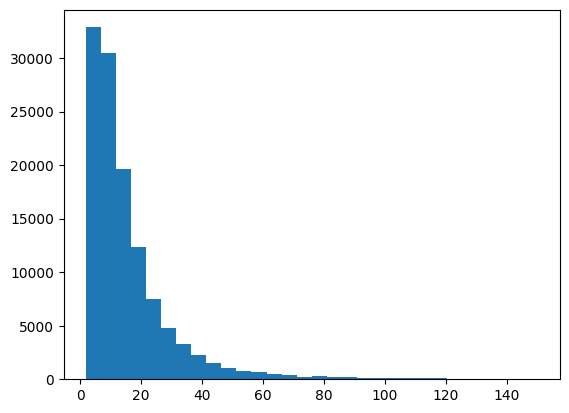

In [13]:
lengths = [len(x) for x,_ in train_dataset]
plt.hist(lengths, bins=30)
plt.show()

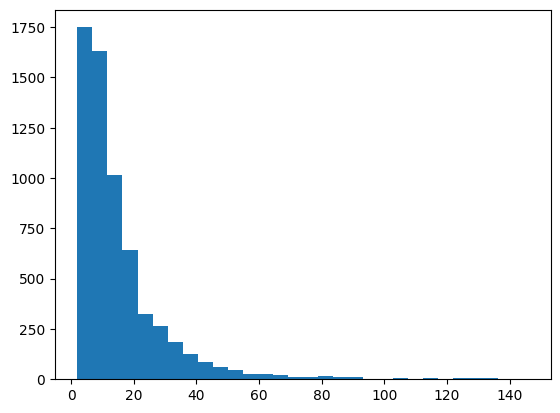

In [14]:
lengths = [len(x) for x,_ in test_dataset]
plt.hist(lengths, bins=30)
plt.show()

## Training

In [15]:
batch_size = 128

train_loader = datasets.DataLoaderPadding(dataset=train_dataset, batch_size=batch_size)
test_loader = datasets.DataLoaderPadding(dataset=test_dataset, batch_size=batch_size)

In [31]:
model = SentimentAnalysisLSTM(embeddings=glove_100, hidden_dim=128, num_layers=2, bidirectional=True, dropout=0.5)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model

SentimentAnalysisLSTM(
  (embedding): Embedding(400001, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)

In [32]:
trainer = Trainer(model=model, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer)

In [33]:
trainer.train(60, verbose=True)

Epoch 1/60
Train loss: 0.358506, accuracy: 84.49%
Val loss:   0.402944, accuracy: 82.56%
-----------------------------
Epoch 2/60
Train loss: 0.302294, accuracy: 87.40%
Val loss:   0.405951, accuracy: 79.26%
-----------------------------
Epoch 3/60
Train loss: 0.276461, accuracy: 88.60%
Val loss:   0.306690, accuracy: 87.35%
-----------------------------
Epoch 4/60
Train loss: 0.255651, accuracy: 89.57%
Val loss:   0.325163, accuracy: 85.62%
-----------------------------
Epoch 5/60
Train loss: 0.239835, accuracy: 90.28%
Val loss:   0.385824, accuracy: 80.45%
-----------------------------
Epoch 6/60
Train loss: 0.225281, accuracy: 90.99%
Val loss:   0.269147, accuracy: 88.90%
-----------------------------
Epoch 7/60
Train loss: 0.208679, accuracy: 91.77%
Val loss:   0.246871, accuracy: 89.84%
-----------------------------
Epoch 8/60
Train loss: 0.196111, accuracy: 92.25%
Val loss:   0.259421, accuracy: 89.27%
-----------------------------
Epoch 9/60
Train loss: 0.182178, accuracy: 92.91

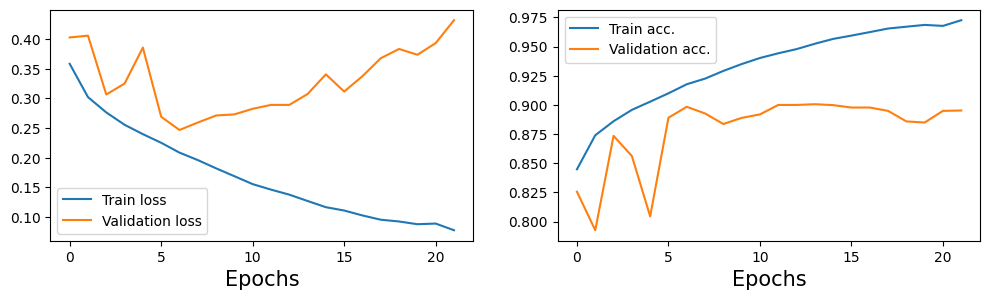

In [34]:
trainer.plot_history()

In [38]:
best_model = trainer.best_model()
best_model.lstm.flatten_parameters()


Loading best params on validation set (epoch 14, accuracy: 90.06%)



In [39]:
trainer.validation(best_model)

(0.30752855023403447, 0.9006024096385542)

In [27]:
model_2 = SentimentAnalysisLSTM(embeddings=glove_200, hidden_dim=32, num_layers=1, bidirectional=True, dropout=0.5)
model_2.to(device)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.001, weight_decay=0.00001)
model_2

SentimentAnalysisLSTM(
  (embedding): Embedding(400001, 200)
  (lstm): LSTM(200, 32, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [32]:
trainer_2 = Trainer(model=model_2, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer_2)

In [48]:
trainer_2.train(20, verbose=True)

Epoch 1/20
Train loss: 0.367373, accuracy: 84.19%
Val loss:   0.413207, accuracy: 80.39%
-----------------------------
Epoch 2/20
Train loss: 0.311016, accuracy: 87.06%
Val loss:   0.334309, accuracy: 86.68%
-----------------------------
Epoch 3/20
Train loss: 0.287747, accuracy: 88.14%
Val loss:   0.343381, accuracy: 85.10%
-----------------------------
Epoch 4/20
Train loss: 0.271233, accuracy: 88.93%
Val loss:   0.310267, accuracy: 87.25%
-----------------------------
Epoch 5/20
Train loss: 0.259202, accuracy: 89.51%
Val loss:   0.298376, accuracy: 87.70%
-----------------------------
Epoch 6/20
Train loss: 0.250297, accuracy: 89.90%
Val loss:   0.297780, accuracy: 87.94%
-----------------------------
Epoch 7/20
Train loss: 0.241672, accuracy: 90.27%
Val loss:   0.333399, accuracy: 84.83%
-----------------------------
Epoch 8/20
Train loss: 0.236143, accuracy: 90.52%
Val loss:   0.307383, accuracy: 86.89%
-----------------------------
Epoch 9/20
Train loss: 0.228864, accuracy: 90.87

In [49]:
trainer_2.optimizer = torch.optim.Adam(model_2.parameters(), lr=0.0003)
trainer_2.train(20, verbose=True)

Epoch 21/40
Train loss: 0.169794, accuracy: 93.51%
Val loss:   0.258032, accuracy: 89.81%
-----------------------------
Epoch 22/40
Train loss: 0.161125, accuracy: 93.89%
Val loss:   0.274444, accuracy: 89.28%
-----------------------------
Epoch 23/40
Train loss: 0.156925, accuracy: 94.01%
Val loss:   0.270521, accuracy: 89.41%
-----------------------------
Epoch 24/40
Train loss: 0.155377, accuracy: 94.12%
Val loss:   0.265415, accuracy: 90.04%
-----------------------------
Epoch 25/40
Train loss: 0.153285, accuracy: 94.19%
Val loss:   0.278130, accuracy: 89.27%
-----------------------------
Epoch 26/40
Train loss: 0.149056, accuracy: 94.41%
Val loss:   0.275305, accuracy: 89.79%
-----------------------------
Epoch 27/40
Train loss: 0.147784, accuracy: 94.44%
Val loss:   0.281653, accuracy: 89.51%
-----------------------------
Epoch 28/40
Train loss: 0.144279, accuracy: 94.62%
Val loss:   0.282692, accuracy: 89.51%
-----------------------------
Epoch 29/40
Train loss: 0.143029, accura

In [50]:
best_model = trainer_2.best_model()
best_model.lstm.flatten_parameters()


Loading best params on validation set (epoch 13, accuracy: 90.38%)



In [30]:
# torch.save(best_model.state_dict(), "../../models/best_LSTM_state_dict.model")
state_dict = torch.load( "../../models/best_LSTM_state_dict.model")
# state_dict
model_2.load_state_dict(state_dict)

<All keys matched successfully>

In [20]:
model_3 = SentimentAnalysisLSTM(embeddings=glove_300, hidden_dim=16, num_layers=3, bidirectional=True, dropout=0.5)
model_3.to(device)
optimizer_3 = torch.optim.Adam(model_3.parameters(), lr=0.001)
model_3

SentimentAnalysisLSTM(
  (embedding): Embedding(400001, 300)
  (lstm): LSTM(300, 16, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [21]:
trainer_3 = Trainer(model=model_3, train_dataLoader=train_loader, val_dataLoader=test_loader, optimizer=optimizer_3)

In [23]:
trainer_3.train(20, verbose=True)

Epoch 21/40
Train loss: 0.187654, accuracy: 92.88%
Val loss:   0.279394, accuracy: 88.98%
-----------------------------
Epoch 22/40
Train loss: 0.187668, accuracy: 92.81%
Val loss:   0.274889, accuracy: 89.06%
-----------------------------
Epoch 23/40
Train loss: 0.185153, accuracy: 93.04%
Val loss:   0.278415, accuracy: 89.12%
-----------------------------
Epoch 24/40
Train loss: 0.183188, accuracy: 93.07%
Val loss:   0.282394, accuracy: 89.32%
-----------------------------
Epoch 25/40
Train loss: 0.179917, accuracy: 93.24%
Val loss:   0.306043, accuracy: 88.73%
-----------------------------
Epoch 26/40
Train loss: 0.175653, accuracy: 93.45%
Val loss:   0.292202, accuracy: 89.27%
-----------------------------
Epoch 27/40
Train loss: 0.174777, accuracy: 93.50%
Val loss:   0.299948, accuracy: 88.92%
-----------------------------
Epoch 28/40
Train loss: 0.174388, accuracy: 93.50%
Val loss:   0.297411, accuracy: 88.68%
-----------------------------
Epoch 29/40
Train loss: 0.175157, accura

In [24]:
trainer_3.best_model()


Loading best params on validation set (epoch 11, accuracy: 89.58%)



SentimentAnalysisLSTM(
  (embedding): Embedding(400001, 300)
  (lstm): LSTM(300, 16, num_layers=3, batch_first=True, dropout=0.5, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

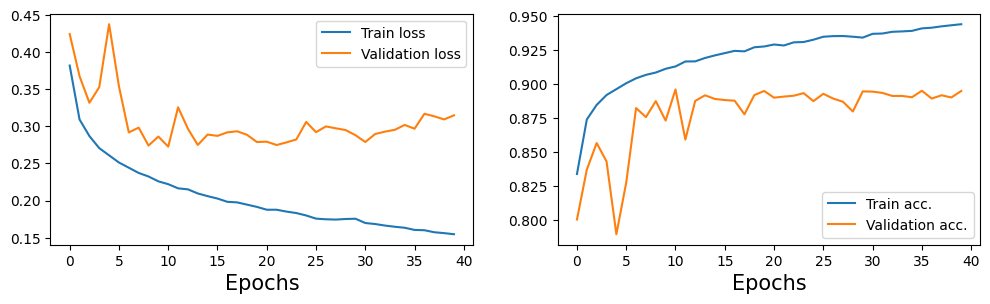

In [25]:
trainer_3.plot_history()

In [79]:
torch.save(best_model.state_dict(), "../../models/best_LSTM_state_dict.model")

## Testing

In [44]:
best_model = model_2
best_model.to(device)
trainer_2.validation(best_model)

(0.21502440703882775, 0.9158211794546608)

In [46]:
trainer_2.validation(best_model, trainer_2.train_dataLoader)

(0.20252574563145792, 0.9200884475781217)

In [49]:
boundary = 0.4

In [67]:
test_high_confidence(test_loader, best_model, low_boundary=boundary)

High confidence samples: 6002/6308 = 95.15%
Accuracy for high confidence samples: 92.1%


In [43]:
all_moves_df = load_sql_to_df("SELECT * FROM english_annotated_moves", "../../chess.db",)[important_columns]
all_moves_df

,position,move,comment,sentiment
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1
3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1
4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0
...,...,...,...,...
326634,rnb5/p2p1P1N/7p/1pR5/6P1/4k3/2P1B3/3Q1RK1 b - ...,b5b4,Pawn,-1
326635,rnb5/p2p1P1N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f7f8q,Check mate in two moves,-1
326636,rnb2Q2/p2p3N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 b -...,d7d6,Pawn,-1
326637,rnb2Q2/p6N/3p3p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f8e8,Check,-1


In [80]:
moves_df_with_preprocessed_comments = dp.prepare_data_for_sentiment_analysis_prediction(moves_df, glove_embbedings.stoi, max_len=150)
moves_df_with_preprocessed_comments

,position,move,comment,sentiment,preprocessed_comment
926668,3brrk1/1q1n1ppp/pp6/2p5/Pn1pPPP1/3P1NN1/1P4QP/...,b7c6,Finally!,-1,"[finally, !]"
1157585,3q1rk1/1p2ppbp/rnp1b1p1/p7/P2P4/2P3PP/2Q1PPB1/...,b6d7,then after,-1,"[then, after]"
934576,5k2/3R3p/6p1/P2N1p2/5P2/4b3/3r3P/5K2 w - - 1 34,f1e1,"[%csl Rd2,Re3]",1,"[[, csl]"
198598,rn2kb1r/p3pppp/2p1bn2/q7/PppP1P2/4PNN1/1P4PP/R...,f1e2,to castle,-1,"[to, castle]"
456010,8/4k3/4p2p/2r3P1/6P1/1Pp5/P5R1/1K6 b - - 0 40,c5g5,[%cal Rh6h5],-1,"[[, cal]"
...,...,...,...,...,...
53334,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,f1b5,"The start of the Ruy lopez, the Spanish game, ...",-1,"[the, start, of, the, ruy, lopez, the, spanish..."
1252861,6k1/R4p1p/1r4p1/3B4/8/4K3/6PP/8 b - - 3 35,b6f6,"By using the Chessbase\nfunction ""similar endi...",-1,"[by, use, the, chessbase, function, similar, e..."
273119,4r1k1/1p3pp1/p1p4p/8/2B2N1B/2b2bP1/P4P1P/5K2 w...,f4g2,"Knowing what kind of trouble I might be in, th...",-1,"[know, what, kind, of, trouble, might, be, in,..."
51476,4r1k1/1p3p2/3p2p1/7p/2r2n2/P1B3P1/1P3PP1/3RR1K...,e1e8,"27. Rxe8 !! As black has only 1 legal move, Kh...",-1,"[as, black, have, only, legal, move, he, can, ..."


In [81]:
moves_df_with_preprocessed_comments = moves_df_with_preprocessed_comments.reset_index()
moves_df_with_preprocessed_comments

,index,position,move,comment,sentiment,preprocessed_comment
0,926668,3brrk1/1q1n1ppp/pp6/2p5/Pn1pPPP1/3P1NN1/1P4QP/...,b7c6,Finally!,-1,"[finally, !]"
1,1157585,3q1rk1/1p2ppbp/rnp1b1p1/p7/P2P4/2P3PP/2Q1PPB1/...,b6d7,then after,-1,"[then, after]"
2,934576,5k2/3R3p/6p1/P2N1p2/5P2/4b3/3r3P/5K2 w - - 1 34,f1e1,"[%csl Rd2,Re3]",1,"[[, csl]"
3,198598,rn2kb1r/p3pppp/2p1bn2/q7/PppP1P2/4PNN1/1P4PP/R...,f1e2,to castle,-1,"[to, castle]"
4,456010,8/4k3/4p2p/2r3P1/6P1/1Pp5/P5R1/1K6 b - - 0 40,c5g5,[%cal Rh6h5],-1,"[[, cal]"
...,...,...,...,...,...,...
909692,53334,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,f1b5,"The start of the Ruy lopez, the Spanish game, ...",-1,"[the, start, of, the, ruy, lopez, the, spanish..."
909693,1252861,6k1/R4p1p/1r4p1/3B4/8/4K3/6PP/8 b - - 3 35,b6f6,"By using the Chessbase\nfunction ""similar endi...",-1,"[by, use, the, chessbase, function, similar, e..."
909694,273119,4r1k1/1p3pp1/p1p4p/8/2B2N1B/2b2bP1/P4P1P/5K2 w...,f4g2,"Knowing what kind of trouble I might be in, th...",-1,"[know, what, kind, of, trouble, might, be, in,..."
909695,51476,4r1k1/1p3p2/3p2p1/7p/2r2n2/P1B3P1/1P3PP1/3RR1K...,e1e8,"27. Rxe8 !! As black has only 1 legal move, Kh...",-1,"[as, black, have, only, legal, move, he, can, ..."


In [82]:
unlabeled_dataset = datasets.PretrainedEmbeddingsIndicesDataset(moves_df_with_preprocessed_comments, glove_embbedings, comment_col="preprocessed_comment")
unlabeled_loader = datasets.DataLoaderPadding(dataset=unlabeled_dataset, batch_size = 128)
predictions = predict(unlabeled_loader, best_model, low_boundary=0.4)
moves_df_with_preprocessed_comments.loc[:, "sentiment"] = predictions.numpy().astype(np.int32)
moves_df_with_preprocessed_comments

,index,position,move,comment,sentiment,preprocessed_comment
0,926668,3brrk1/1q1n1ppp/pp6/2p5/Pn1pPPP1/3P1NN1/1P4QP/...,b7c6,Finally!,1,"[finally, !]"
1,1157585,3q1rk1/1p2ppbp/rnp1b1p1/p7/P2P4/2P3PP/2Q1PPB1/...,b6d7,then after,1,"[then, after]"
2,934576,5k2/3R3p/6p1/P2N1p2/5P2/4b3/3r3P/5K2 w - - 1 34,f1e1,"[%csl Rd2,Re3]",1,"[[, csl]"
3,198598,rn2kb1r/p3pppp/2p1bn2/q7/PppP1P2/4PNN1/1P4PP/R...,f1e2,to castle,1,"[to, castle]"
4,456010,8/4k3/4p2p/2r3P1/6P1/1Pp5/P5R1/1K6 b - - 0 40,c5g5,[%cal Rh6h5],1,"[[, cal]"
...,...,...,...,...,...,...
909692,53334,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,f1b5,"The start of the Ruy lopez, the Spanish game, ...",1,"[the, start, of, the, ruy, lopez, the, spanish..."
909693,1252861,6k1/R4p1p/1r4p1/3B4/8/4K3/6PP/8 b - - 3 35,b6f6,"By using the Chessbase\nfunction ""similar endi...",-1,"[by, use, the, chessbase, function, similar, e..."
909694,273119,4r1k1/1p3pp1/p1p4p/8/2B2N1B/2b2bP1/P4P1P/5K2 w...,f4g2,"Knowing what kind of trouble I might be in, th...",0,"[know, what, kind, of, trouble, might, be, in,..."
909695,51476,4r1k1/1p3p2/3p2p1/7p/2r2n2/P1B3P1/1P3PP1/3RR1K...,e1e8,"27. Rxe8 !! As black has only 1 legal move, Kh...",1,"[as, black, have, only, legal, move, he, can, ..."


In [83]:
classified_comments = moves_df_with_preprocessed_comments[moves_df_with_preprocessed_comments.sentiment.isin([0,1])].reset_index()
classified_comments

,level_0,index,position,move,comment,sentiment,preprocessed_comment
0,0,926668,3brrk1/1q1n1ppp/pp6/2p5/Pn1pPPP1/3P1NN1/1P4QP/...,b7c6,Finally!,1,"[finally, !]"
1,1,1157585,3q1rk1/1p2ppbp/rnp1b1p1/p7/P2P4/2P3PP/2Q1PPB1/...,b6d7,then after,1,"[then, after]"
2,2,934576,5k2/3R3p/6p1/P2N1p2/5P2/4b3/3r3P/5K2 w - - 1 34,f1e1,"[%csl Rd2,Re3]",1,"[[, csl]"
3,3,198598,rn2kb1r/p3pppp/2p1bn2/q7/PppP1P2/4PNN1/1P4PP/R...,f1e2,to castle,1,"[to, castle]"
4,4,456010,8/4k3/4p2p/2r3P1/6P1/1Pp5/P5R1/1K6 b - - 0 40,c5g5,[%cal Rh6h5],1,"[[, cal]"
...,...,...,...,...,...,...,...
835328,909691,41352,rnbqkb1r/pppp1ppp/4pn2/8/2PP4/5N2/PP2PPPP/RNBQ...,b7b6,(graderguy) b6: We are now in pretty familiar ...,1,"[we, be, now, in, pretty, familiar, territory,..."
835329,909692,53334,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,f1b5,"The start of the Ruy lopez, the Spanish game, ...",1,"[the, start, of, the, ruy, lopez, the, spanish..."
835330,909694,273119,4r1k1/1p3pp1/p1p4p/8/2B2N1B/2b2bP1/P4P1P/5K2 w...,f4g2,"Knowing what kind of trouble I might be in, th...",0,"[know, what, kind, of, trouble, might, be, in,..."
835331,909695,51476,4r1k1/1p3p2/3p2p1/7p/2r2n2/P1B3P1/1P3PP1/3RR1K...,e1e8,"27. Rxe8 !! As black has only 1 legal move, Kh...",1,"[as, black, have, only, legal, move, he, can, ..."


In [84]:
classified_comments_to_save = classified_comments[['position', 'move', 'comment', 'sentiment']]
save_to_sql(classified_comments_to_save, "../../chess.db", "chessbase_gameknot_classified_moves")

In [54]:
con = db.connect("../../chess.db")
classified_comments.sentiment =  pd.to_numeric(classified_comments.sentiment)
classified_comments_to_save = classified_comments[['position', 'move', 'comment', 'sentiment']]
classified_comments_to_save.to_sql('classified_moves', con, if_exists='replace')

276891

In [47]:
angelfire_moves = load_sql_to_df("SELECT * FROM angelfire_moves", "../../chess.db")[['position', 'move', 'comment']]
angelfire_moves['sentiment'] = -1
angelfire_moves

,position,move,comment,sentiment
0,r1bq1rk1/2p1bppp/p1n2n2/1p1pp3/4P3/1BP2N2/PP1P...,d2d3,"An excellent reply, avoiding the complications...",-1
1,r3r1k1/1b2bppp/p1n2n2/1ppqp1B1/8/2PP1N2/PPB1QP...,g5h4,threatening to win the e-pawn with Bg3 as well...,-1
2,r3r1k1/1b2bppp/p1n2n2/1ppqp3/7B/2PP1N2/PPB1QPP...,a8d8,Apparently Black still stands very well. His p...,-1
3,3rr1k1/1b2bppp/p1n2n2/1ppqp3/7B/2PP1N2/PPB1QPP...,c2b3,This deep moves demonstrates otherwise,-1
4,4r1k1/1b2bppp/p4n2/1pp1R3/7B/1BPr4/PP3PPP/R4NK...,c5c4,"The Black pieces are\nawkardly ties up, while ...",-1
...,...,...,...,...
27500,2Q2b1k/1p3q2/p6p/5n2/3p1r2/5NR1/PP3K2/7R w - -...,g3h3,"White defends very\nactively, with his major p...",-1
27501,2Q2b1k/1p3q2/p6p/5n2/3p1r2/5N1R/PP3K2/7R b - -...,d4d3,"A decoy, to tempt the White Queen\naway from t...",-1
27502,5b1k/1p6/p6p/5n2/5r2/3Q1N1R/P3K3/q6R b - - 3 43,a1a2,And this brings about a very unusual middlegam...,-1
27503,5b1k/1p6/p6p/5n2/5r2/3Q3R/q2NK3/7R b - - 1 44,f4d4,Consistent chess. Black hammers away at the\nw...,-1


In [48]:
angelfire_moves_preprocessed = dp.prepare_data_for_sentiment_analysis_prediction(angelfire_moves, glove_embbedings.stoi, max_len=150)
angelfire_moves_preprocessed

,position,move,comment,sentiment,preprocessed_comment
10630,8/5p2/r5p1/P1k4p/7P/1K4P1/R4P2/8 w - - 8 61,b3c3,Zugzwang.,-1,"[zugzwang, .]"
25101,3r4/4k3/pp4p1/3PK2p/PP6/5R1P/6P1/8 w - - 9 48,d5d6,(!)\n48...,-1,"[!, ...]"
26095,5rk1/pp2b3/4pnR1/3p4/3Q4/5q2/PPP2P2/1K5R b - -...,g8f7,threatening ...Kf7xg6 or ...Qf3xh1+,-1,"[threaten, or]"
12159,r1b2rk1/pppnbppp/4p3/q7/3P4/P1N2N2/1PPQ1PPP/1K...,a5b6,Black threatens 13...Bxa3.,-1,"[black, threaten]"
27151,8/1K2k3/1P4p1/2R5/8/6r1/8/8 b - - 2 73,e7d7,To prevent Kc7.,-1,"[to, prevent]"
...,...,...,...,...,...
9698,r7/Pk6/8/1n1K4/8/8/8/R7 b - - 10 67,b5a7,A theory draw\nyou would think in an elite tou...,-1,"[a, theory, draw, you, would, think, in, an, e..."
9110,r2qkb1r/ppp1pppp/2npbn2/8/7N/2NPB3/PPP1PPPP/R2...,c6a5,Idea: Do not move a piece a second time in the...,-1,"[idea, do, not, move, a, piece, a, second, tim..."
20692,3q1rk1/5ppp/Q2bbn2/3p2B1/8/2N2N2/Pr3PPP/3RR1K1...,g5f6,Making things easier for Kasparov. The world #...,-1,"[make, thing, easy, for, kasparov, ., the, wor..."
13462,1nqr1r1k/1bp1b3/p5Q1/1p1P4/n7/7P/PP1B1PP1/R3R1...,e1e7,"... and Bidev resigned. There is, in truth, n...",-1,"[..., and, resign, ., there, be, in, truth, no..."


In [50]:
unlabeled_dataset = datasets.PretrainedEmbeddingsIndicesDataset(angelfire_moves_preprocessed, glove_embbedings, comment_col="preprocessed_comment")
unlabeled_loader = datasets.DataLoaderPadding(dataset=unlabeled_dataset, batch_size = 128)
predictions = predict(unlabeled_loader, model_2, low_boundary=boundary)
angelfire_moves_preprocessed.loc[:, "sentiment"] = predictions.numpy().astype(np.int32)
angelfire_moves_preprocessed

,position,move,comment,sentiment,preprocessed_comment
10630,8/5p2/r5p1/P1k4p/7P/1K4P1/R4P2/8 w - - 8 61,b3c3,Zugzwang.,1,"[zugzwang, .]"
25101,3r4/4k3/pp4p1/3PK2p/PP6/5R1P/6P1/8 w - - 9 48,d5d6,(!)\n48...,1,"[!, ...]"
26095,5rk1/pp2b3/4pnR1/3p4/3Q4/5q2/PPP2P2/1K5R b - -...,g8f7,threatening ...Kf7xg6 or ...Qf3xh1+,1,"[threaten, or]"
12159,r1b2rk1/pppnbppp/4p3/q7/3P4/P1N2N2/1PPQ1PPP/1K...,a5b6,Black threatens 13...Bxa3.,1,"[black, threaten]"
27151,8/1K2k3/1P4p1/2R5/8/6r1/8/8 b - - 2 73,e7d7,To prevent Kc7.,1,"[to, prevent]"
...,...,...,...,...,...
9698,r7/Pk6/8/1n1K4/8/8/8/R7 b - - 10 67,b5a7,A theory draw\nyou would think in an elite tou...,1,"[a, theory, draw, you, would, think, in, an, e..."
9110,r2qkb1r/ppp1pppp/2npbn2/8/7N/2NPB3/PPP1PPPP/R2...,c6a5,Idea: Do not move a piece a second time in the...,0,"[idea, do, not, move, a, piece, a, second, tim..."
20692,3q1rk1/5ppp/Q2bbn2/3p2B1/8/2N2N2/Pr3PPP/3RR1K1...,g5f6,Making things easier for Kasparov. The world #...,1,"[make, thing, easy, for, kasparov, ., the, wor..."
13462,1nqr1r1k/1bp1b3/p5Q1/1p1P4/n7/7P/PP1B1PP1/R3R1...,e1e7,"... and Bidev resigned. There is, in truth, n...",1,"[..., and, resign, ., there, be, in, truth, no..."


In [64]:
angelfire_moves.dtypes

position                object
move                    object
comment                 object
sentiment                int64
preprocessed_comment    object
dtype: object

In [51]:
classified_comments_angelfire = angelfire_moves_preprocessed[angelfire_moves_preprocessed.sentiment.isin([0,1])].reset_index()
classified_comments_angelfire

,index,position,move,comment,sentiment,preprocessed_comment
0,10630,8/5p2/r5p1/P1k4p/7P/1K4P1/R4P2/8 w - - 8 61,b3c3,Zugzwang.,1,"[zugzwang, .]"
1,25101,3r4/4k3/pp4p1/3PK2p/PP6/5R1P/6P1/8 w - - 9 48,d5d6,(!)\n48...,1,"[!, ...]"
2,26095,5rk1/pp2b3/4pnR1/3p4/3Q4/5q2/PPP2P2/1K5R b - -...,g8f7,threatening ...Kf7xg6 or ...Qf3xh1+,1,"[threaten, or]"
3,12159,r1b2rk1/pppnbppp/4p3/q7/3P4/P1N2N2/1PPQ1PPP/1K...,a5b6,Black threatens 13...Bxa3.,1,"[black, threaten]"
4,27151,8/1K2k3/1P4p1/2R5/8/6r1/8/8 b - - 2 73,e7d7,To prevent Kc7.,1,"[to, prevent]"
...,...,...,...,...,...,...
24437,9698,r7/Pk6/8/1n1K4/8/8/8/R7 b - - 10 67,b5a7,A theory draw\nyou would think in an elite tou...,1,"[a, theory, draw, you, would, think, in, an, e..."
24438,9110,r2qkb1r/ppp1pppp/2npbn2/8/7N/2NPB3/PPP1PPPP/R2...,c6a5,Idea: Do not move a piece a second time in the...,0,"[idea, do, not, move, a, piece, a, second, tim..."
24439,20692,3q1rk1/5ppp/Q2bbn2/3p2B1/8/2N2N2/Pr3PPP/3RR1K1...,g5f6,Making things easier for Kasparov. The world #...,1,"[make, thing, easy, for, kasparov, ., the, wor..."
24440,13462,1nqr1r1k/1bp1b3/p5Q1/1p1P4/n7/7P/PP1B1PP1/R3R1...,e1e7,"... and Bidev resigned. There is, in truth, n...",1,"[..., and, resign, ., there, be, in, truth, no..."


In [53]:
con = db.connect("../../chess.db")
classified_comments_angelfire.sentiment =  pd.to_numeric(classified_comments_angelfire.sentiment)
classified_comments_to_save = classified_comments_angelfire[['position', 'move', 'comment', 'sentiment']]
classified_comments_to_save.to_sql('chessbase_gameknot_classified_moves', con, if_exists='append')

24442